# LSTM-Solar-Production-ERCOT
The goal of this project is to create a machine learning pipeline that utilizes long short-term memory (LSTM) to predict aggregate solar energy production throughout Texas's ERCOT grid.

Texas is of particular interest for the following reasons: 

1. It has extreme solar irradiance
2. It contains the majority of utility-scale solar installations
3. It experiences the most significant transmission constraints
4. It has the most pronounced price effects due to renewable generation


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

print(os.getcwd())

SolarData = pd.read_csv("../Data/SolarData.csv")
SolarData.isna().sum()

c:\Users\Michael Gray\Documents\LSTM Solar Production\Models


Time (Hour-Ending)               0
Date                             0
ERCOT.LOAD                       0
ERCOT.PVGR.GEN                   0
Total Solar Installed, MW        0
Solar Output, % of Load          0
Solar Output, % of Installed     0
Solar 1-hr MW change             3
Solar 1-hr % change              3
Daytime Hour                    24
Ramping Daytime Hour            24
dtype: int64

### Basic Data Visualization and Statistical Tests:

Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Date range: 2022-01-01 01:00:00 to 2025-01-01 00:00:00
Number of observations: 26304


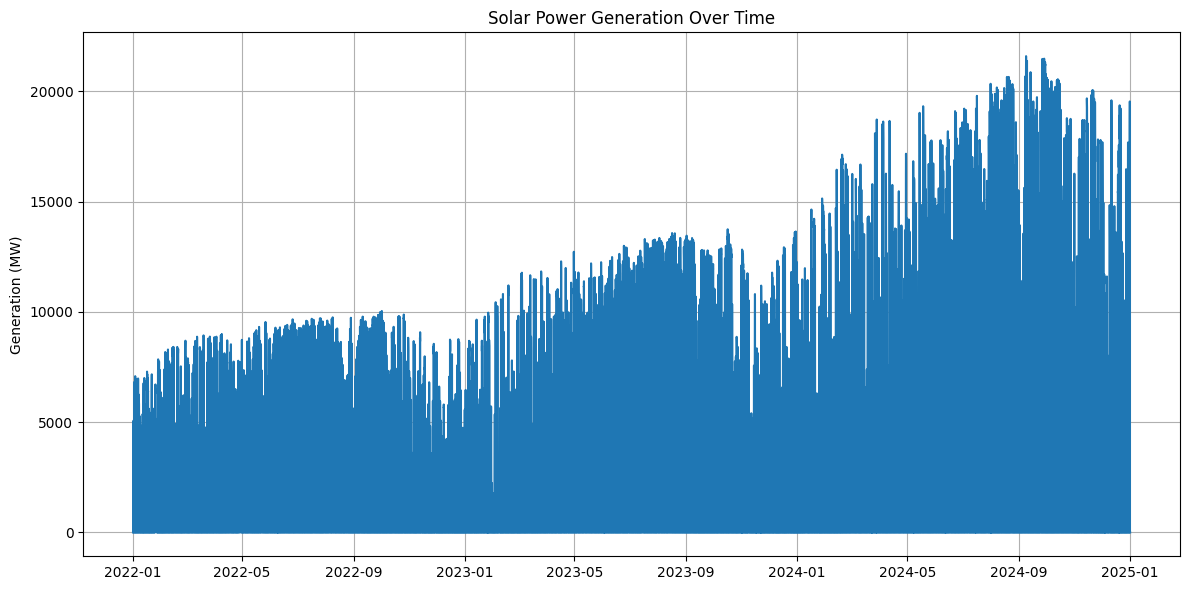

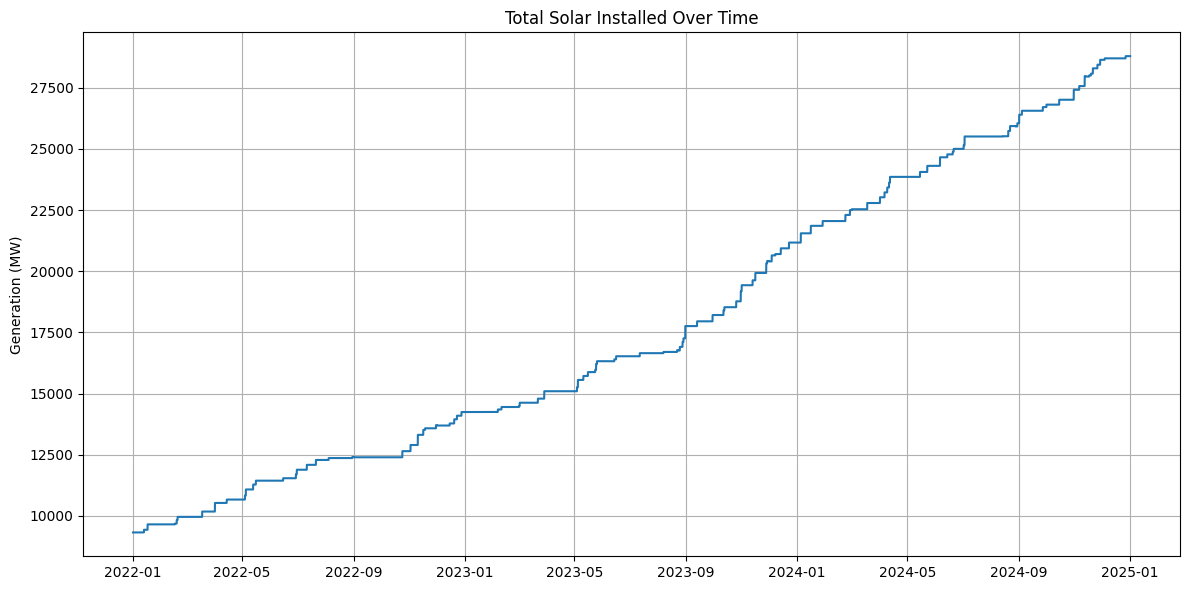

ADF Statistic: -7.747723834768112
p-value: 1.0213526304283474e-11
Critical Values:
	1%: -3.430599102593299
	5%: -2.8616500960359854
	10%: -2.5668286008605627
Result: The series is stationary (p-value < 0.05)


In [ ]:
SolarData = pd.read_csv("../Data/SolarData.csv")

SolarData['Time (Hour-Ending)'] = pd.to_datetime(SolarData['Time (Hour-Ending)'])
SolarData = SolarData.set_index('Time (Hour-Ending)')
print(f"Index type: {type(SolarData.index)}")
print(f"Date range: {SolarData.index.min()} to {SolarData.index.max()}")
print(f"Number of observations: {len(SolarData)}")

# Time series plot of Solar Generated Over Time
plt.figure(figsize=(12,6))
plt.plot(SolarData.index, SolarData['ERCOT.PVGR.GEN'])
plt.title('Solar Power Generation Over Time')
plt.ylabel('Generation (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Time series plot of Solar Installed Over Time
plt.figure(figsize=(12,6))
plt.plot(SolarData.index, SolarData['Total Solar Installed, MW'])
plt.title('Total Solar Installed Over Time')
plt.ylabel('Generation (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()


solar_series = SolarData['ERCOT.PVGR.GEN'].dropna()
result = adfuller(solar_series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


if result[1] < 0.05:
    print("Result: The series is stationary (p-value < 0.05)")
else:
    print("Result: The series is non-stationary (p-value >= 0.05)")


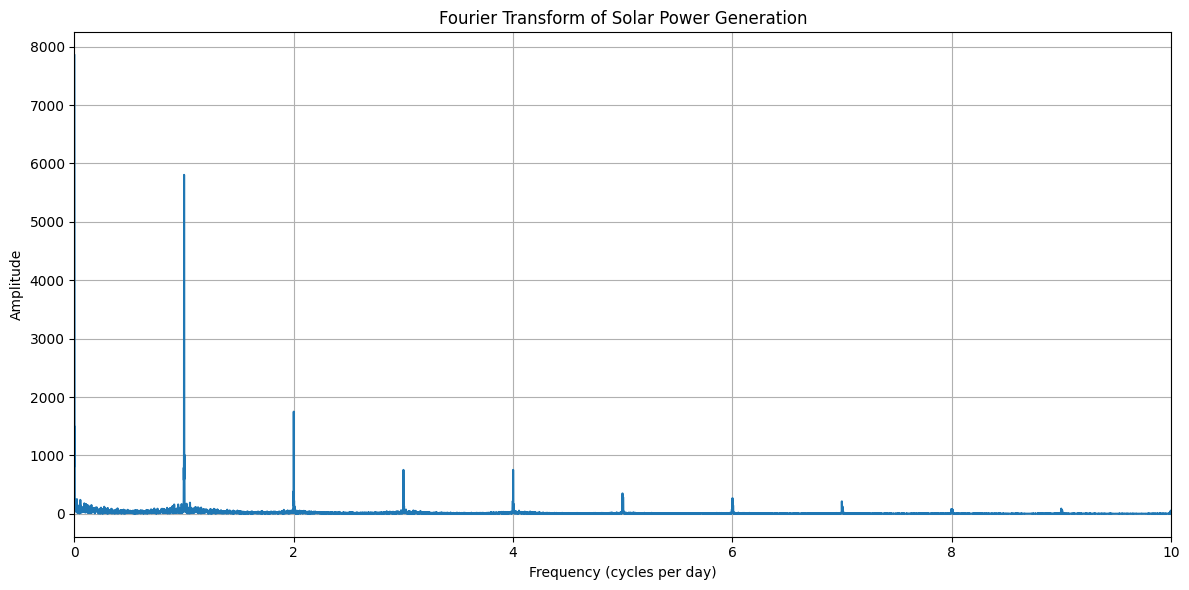

Dominant frequencies (cycles per day): [1.00091241e+00 9.12408759e-04 2.73722628e-03 2.00000000e+00
 1.00000000e+00]
Corresponding periods (days): [9.99088423e-01 1.09600000e+03 3.65333333e+02 5.00000000e-01
 1.00000000e+00]


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq

# Your existing code to load and prepare data
SolarData = pd.read_csv("../Data/SolarData.csv")
SolarData['Time (Hour-Ending)'] = pd.to_datetime(SolarData['Time (Hour-Ending)'])
SolarData = SolarData.set_index('Time (Hour-Ending)')

# Extract the signal for FFT analysis
y = SolarData['ERCOT.PVGR.GEN'].values  # Get the values as a numpy array

# Apply FFT
N = len(y)  # Use the actual length of your data instead of 600
T = 1.0 / 24.0  # For hourly data, sampling rate is 24 samples per day

# Compute the FFT
yf = fft(y)
xf = fftfreq(N, T)[:N//2]  # Only positive frequencies

# Plot the FFT
plt.figure(figsize=(12, 6))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid(True)
plt.title('Fourier Transform of Solar Power Generation')
plt.xlabel('Frequency (cycles per day)')
plt.ylabel('Amplitude')

# Limit x-axis to make the relevant frequencies more visible
plt.xlim(0, 10)  # Focus on frequencies up to 10 cycles per day
plt.tight_layout()
plt.show()

# Optional: Plot the dominant frequencies (excluding the DC component)
dominant_freq_indices = np.argsort(np.abs(yf[1:N//2]))[-5:]  # Top 5 frequencies
dominant_freqs = xf[dominant_freq_indices + 1]  # +1 because we excluded the first element
print("Dominant frequencies (cycles per day):", dominant_freqs)
print("Corresponding periods (days):", 1/dominant_freqs)

Data shape: (26304, 1)
Training data size: (21043, 1)
Testing data size: (5261, 1)
X_train shape: (21019, 24, 1)
y_train shape: (21019,)
X_test shape: (5237, 24, 1)
y_test shape: (5237,)


c:\Users\mgray\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0132 - val_loss: 0.0067
Epoch 2/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 3/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 4/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 5/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 6/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8.8911e-04 - val_loss: 0.0030
Epoch 7/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 9.8661e-04 - val_loss: 0.0020
Epoch 8/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7.9606e-04 - val_loss: 0.0018
Epoch 9/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8.4183e-04 - val_loss: 0.0018
Epoch 10/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8.4617e-04 - val_loss: 0.0020
Epoch 11/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7.7446e-04 - val_loss: 0.0020
Epoch 12/20
657/657 ━━━━━━━━

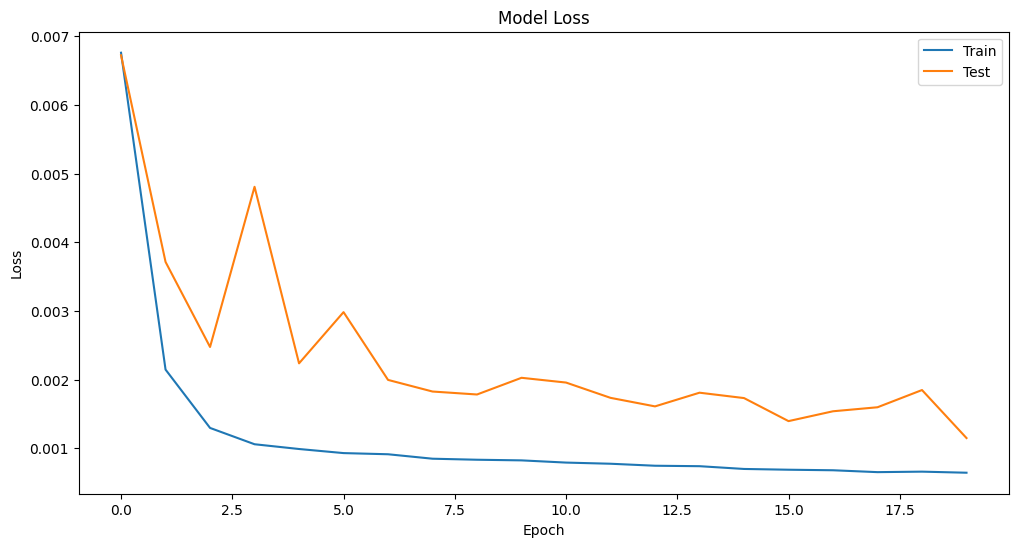

657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train RMSE: 525.26
Test RMSE: 732.02
Train MAE: 280.42
Test MAE: 390.41
Train R²: 0.99
Test R²: 0.99


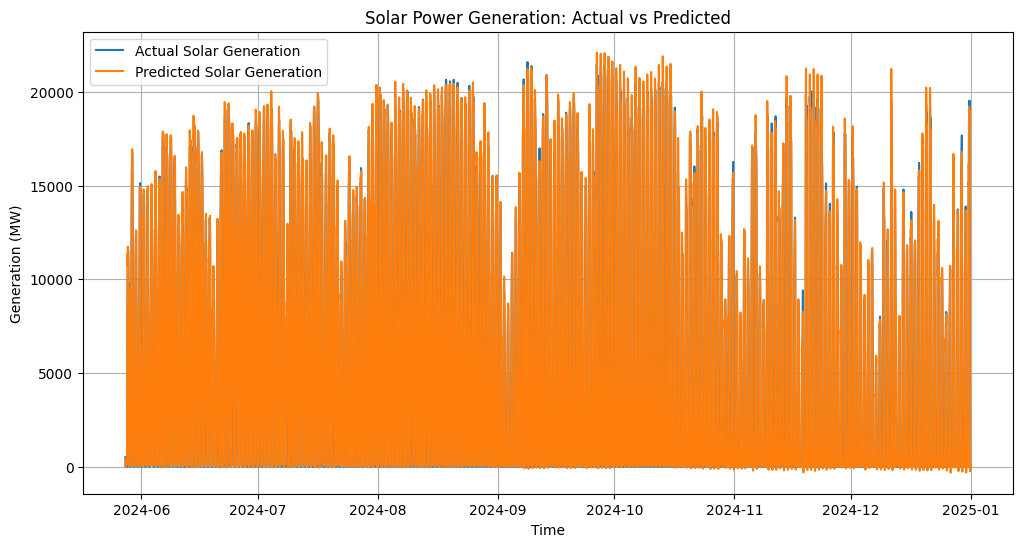

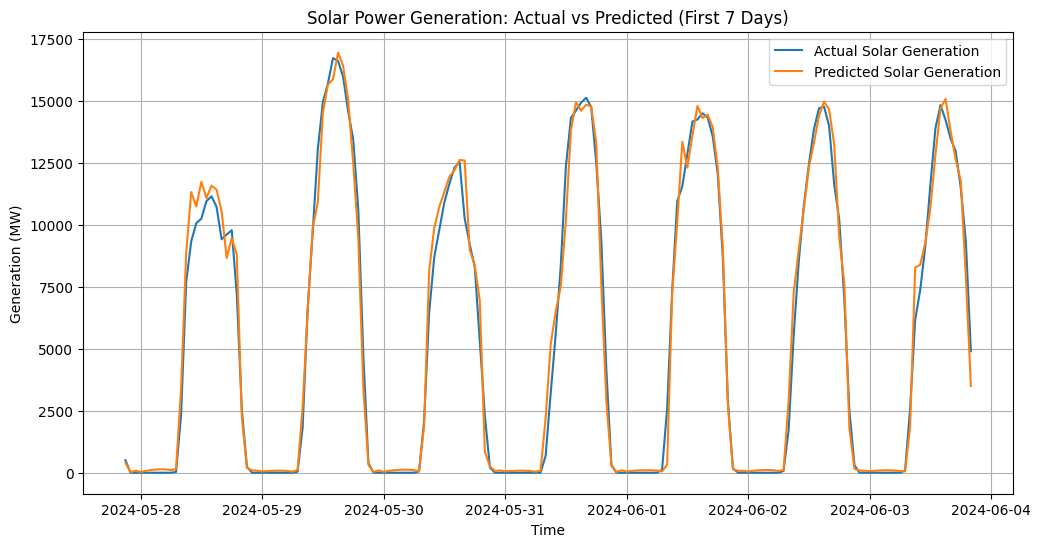

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Extract the solar generation data
data = SolarData['ERCOT.PVGR.GEN'].values.reshape(-1, 1)

# Scale the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Display the shape of our data
print(f"Data shape: {data.shape}")

# Define the training-test split ratio (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

# Split the data
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:, :]

print(f"Training data size: {train_data.shape}")
print(f"Testing data size: {test_data.shape}")

# Function to create sequences for LSTM
def create_dataset(dataset, time_steps=24):
    """
    Create sequences of data for LSTM model.
    
    Args:
        dataset: Input time series data
        time_steps: Number of previous time steps to use as input features
        
    Returns:
        X: Input sequences
        y: Target values
    """
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        # Create a sequence of length time_steps
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        # Target is the next value after the sequence
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)

# Use 24 hours (1 day) of data to predict the next hour
time_steps = 24
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape input to be [samples, time steps, features] as required by LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Create a Sequential model
model = Sequential()

# Add an LSTM layer with 50 units
# return_sequences=False because we only want the last output
model.add(LSTM(units=50, input_shape=(time_steps, 1)))

# Add a Dense output layer with a single neuron
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()

# Train the model
batch_size = 32
epochs = 20

history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_test, y_test),
    verbose=1
)

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions back to original scale
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate performance metrics
# 1. Root Mean Squared Error (RMSE)
train_rmse = math.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test_actual, test_predict))

# 2. Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual, train_predict)
test_mae = mean_absolute_error(y_test_actual, test_predict)

# 3. R-squared (coefficient of determination)
train_r2 = r2_score(y_train_actual, train_predict)
test_r2 = r2_score(y_test_actual, test_predict)

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Train R²: {train_r2:.2f}")
print(f"Test R²: {test_r2:.2f}")

# Create a time axis for the test data
# We need to offset by time_steps to align with the original time index
test_time_index = SolarData.index[train_size + time_steps:train_size + time_steps + len(test_predict)]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_time_index, y_test_actual, label='Actual Solar Generation')
plt.plot(test_time_index, test_predict, label='Predicted Solar Generation')
plt.title('Solar Power Generation: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Generation (MW)')
plt.legend()
plt.grid(True)
plt.show()

# Zoom in to see a shorter time period (e.g., 7 days)
zoom_days = 7
zoom_hours = zoom_days * 24
if len(test_time_index) > zoom_hours:
    plt.figure(figsize=(12, 6))
    plt.plot(test_time_index[:zoom_hours], y_test_actual[:zoom_hours], label='Actual Solar Generation')
    plt.plot(test_time_index[:zoom_hours], test_predict[:zoom_hours], label='Predicted Solar Generation')
    plt.title(f'Solar Power Generation: Actual vs Predicted (First {zoom_days} Days)')
    plt.xlabel('Time')
    plt.ylabel('Generation (MW)')
    plt.legend()
    plt.grid(True)
    plt.show()


    